# AJOUT de l'interaction

In [1]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDBscratch"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [2]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG

%matplotlib notebook
#%matplotlib widget
import matplotlib.pyplot as plt

#### Visualisation des abondances et Pathway pour chaque protéine
Nous allons représenter la relation entre l'abondance des protéines (**Log2 Corrected Abundance Ratio**)  et la précision de la mesure (**LOG10 Adj.P-val**). Ceci se fera à l'aide de la commande matplotlibb [scatter](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html).
###### Volcano Plot global
* Creer la fonction drawScatter(abundanceList, precisionList) qui produira le graphique.
* Creer la fonction drawScatterPathway(goTermsList) 
    * Unique argument qui est une liste n goTerm aux p-value les plus faibles.
    * Dessine les protéines annotées par ces termes GO
    * Colorie de la même couleur, les protéines du même pathway
    * Si une protéine appartient à différents pathway, la priorité ira à celui de p-value la plus faible.

Au maximum 20 pathways pourront être représentés simultanément, vous utiliserez les [cartes de couleurs catégorielles](https://matplotlib.org/examples/color/colormaps_reference.html)

######  Volcano Plot interactif

Il serait plus intéressant de colorier les protéines d'un pathway donné à la volée, en mettant à jour le scatter plot à chaque fois. Jupyter fournit une libraire de composant interactif appelés [widgets](https://ipywidgets.readthedocs.io/en/stable/user_guide.html). 

* Construisez un widget `Dropdown` listant les pathway.

<IPython.core.display.Javascript object>


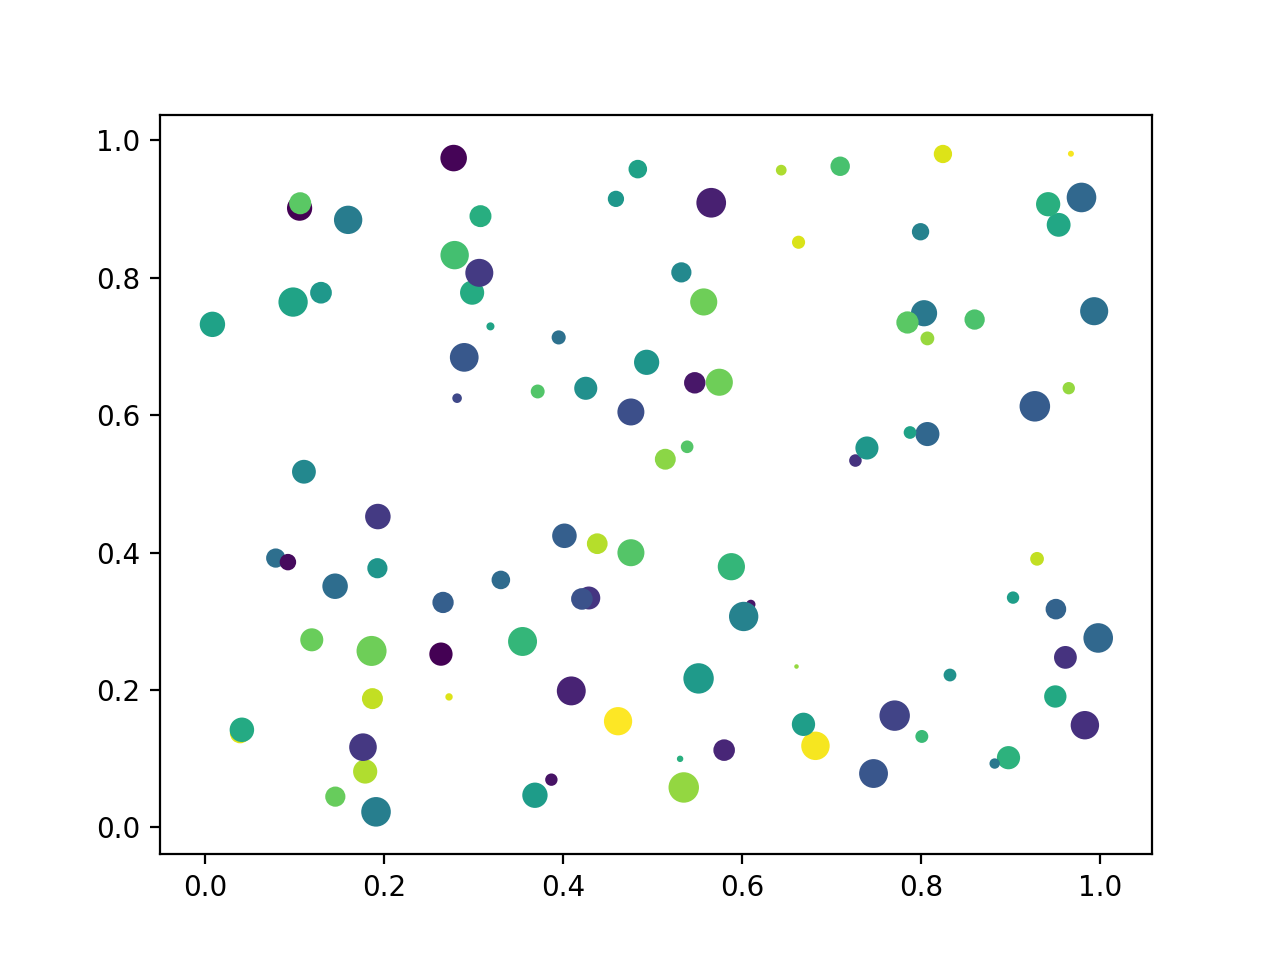

In [13]:
#%matplotlib notebook

x, y, c, s = np.random.rand(4, 100)

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, 100*s, c)
text = ax1.text(0,0, "", va="bottom", ha="left")
#fig.savefig('pscoll.eps')
cid = fig.canvas.mpl_connect('button_press_event', onclick)


<IPython.core.display.Javascript object>


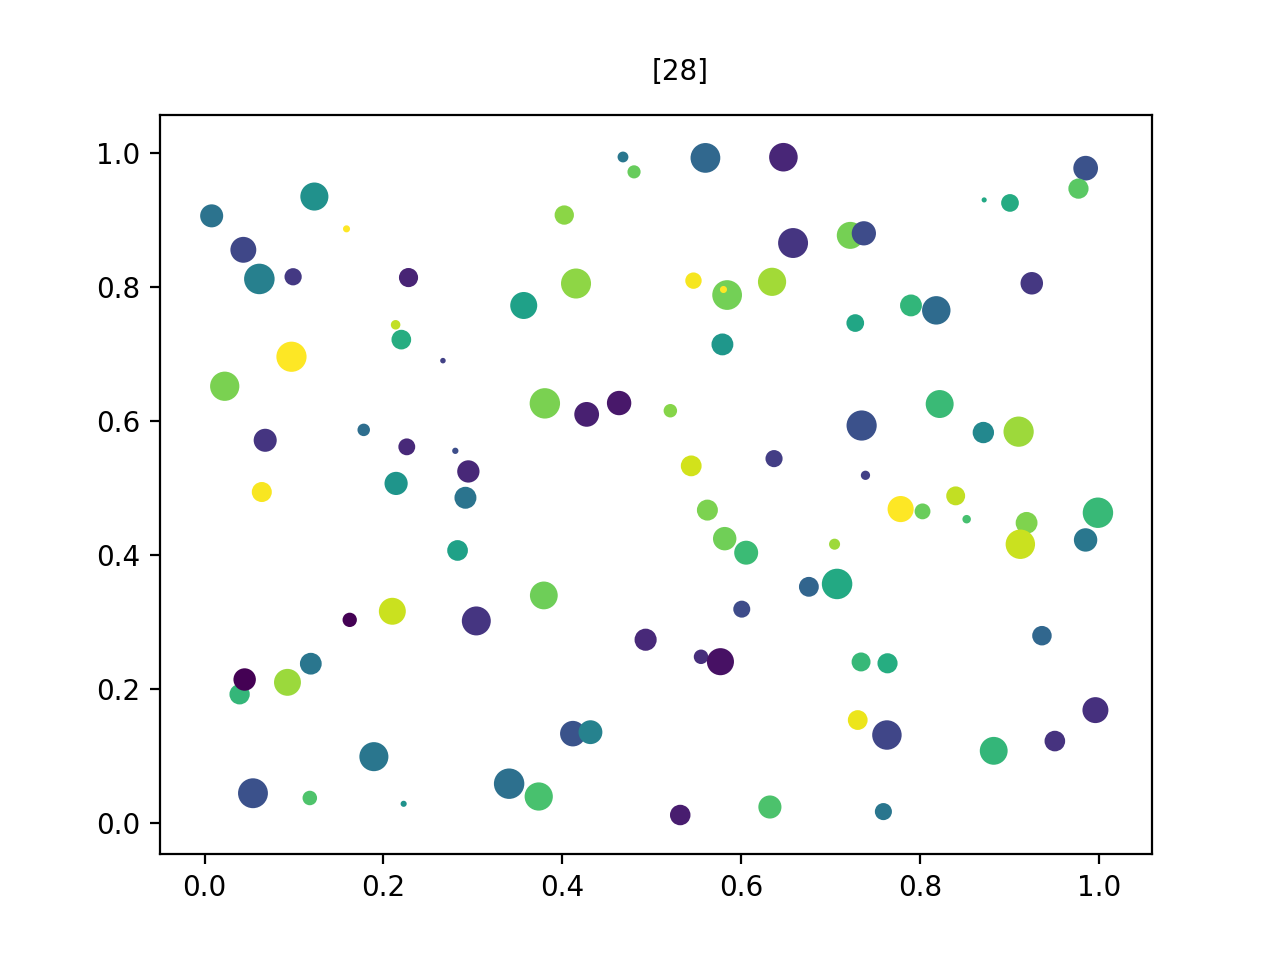

In [16]:
%matplotlib notebook
#%matplotlib widget
x, y, c, s = np.random.rand(4, 100)

def onpick(event):
    ind = event.ind
    tx = str(ind)
    text.set_text(tx)
    #print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
col = ax1.scatter(x, y, 100*s, c, picker=True)
text = ax1.text(0.5,1.1, "", va="bottom", ha="left")
#fig.savefig('pscoll.eps')
cid = fig.canvas.mpl_connect('pick_event', onpick)


##### Read-in data
* Array of protein names
* Array of abundace ratios
* Array of experimental pValue

In [20]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")

dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)
dfClean.loc[:,'LOG10 Adj.P-val'] = dfClean.loc[:,'LOG10 Adj.P-val'].astype(float)


saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
allList = dfClean[ : ]['Accession'].tolist()
pvalue = dfClean[ : ]['LOG10 Adj.P-val'].tolist()
abundance = dfClean[ : ]['Log2 Corrected Abundance Ratio'].tolist()

#dfClean.head()
#print(pvalue)

<IPython.core.display.Javascript object>


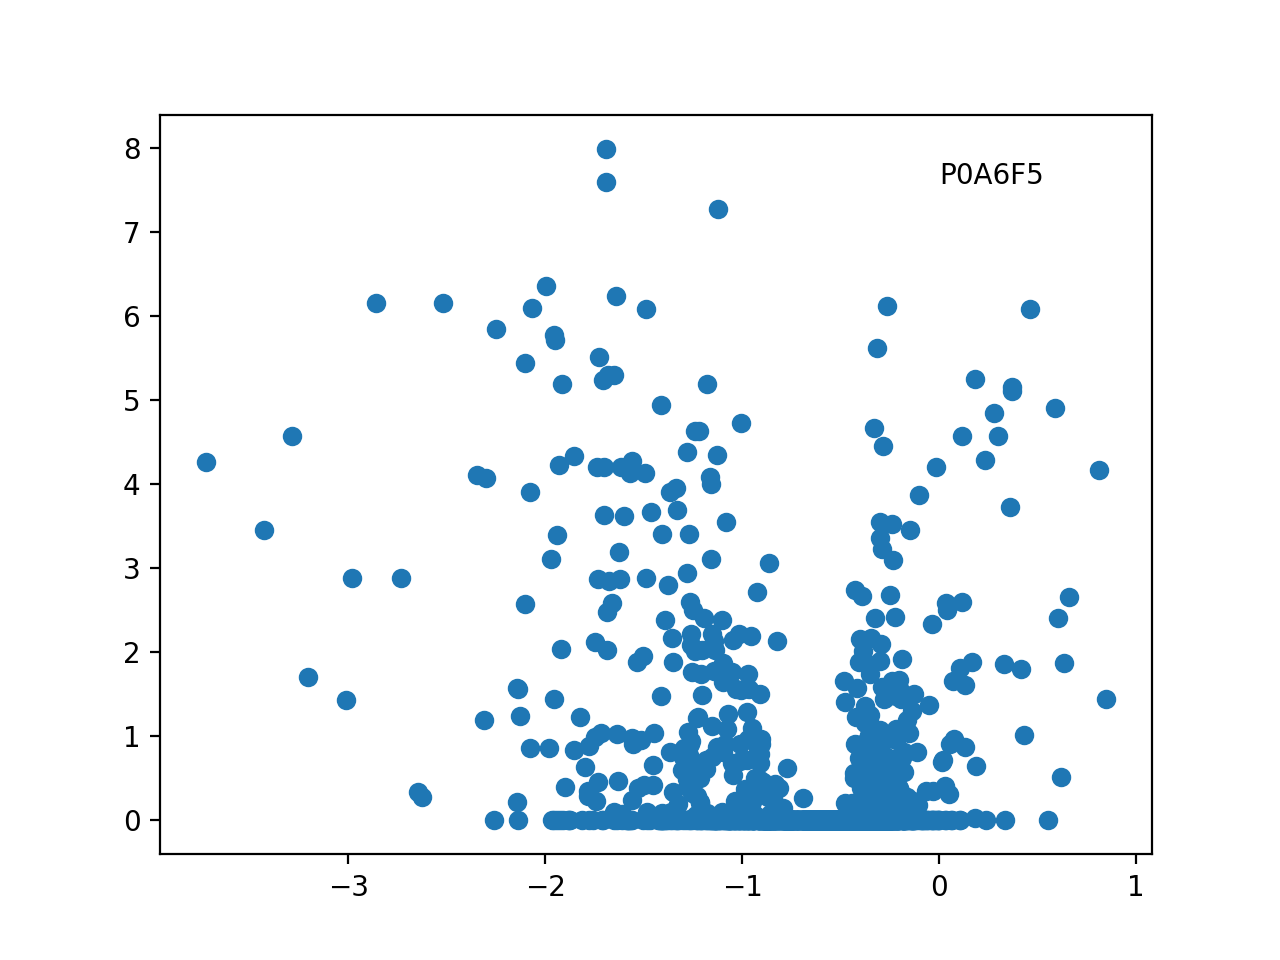

In [26]:
%matplotlib notebook
#%matplotlib widget
#x, y, c, s = np.random.rand(4, 100)
x,y, labels = (abundance, pvalue, allList)
def onpick(event):
    ind = event.ind
    tx = str(ind)
    msg = '\n'.join([ str(labels[i]) for i in ind ])
    text.set_text(msg)
    #print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
#col = ax1.scatter(x, y, 100*s, c, picker=True)

col = ax1.scatter(x, y, picker=True)

text = ax1.text(0, 7.5, "", va="bottom", ha="left")
#fig.savefig('pscoll.eps')
cid = fig.canvas.mpl_connect('pick_event', onpick)